## CORDIC Testbench


This notebook is to test the implementation of a CORDIC running on the programmable logic. The CORDIC is used to convert cartesian to polar coordinates. The output is compared with a Python calculation of the coordinate transform. It takes in x and y and gives out r and theta where r is the radius and theta is the angle.

In [5]:
from pynq import Overlay
from pynq import MMIO
import numpy as np
import struct
import binascii
import cmath
import random
import matplotlib.pyplot as plt



In [6]:
ol=Overlay('./design_2_wrapper.bit') #Change name of bitstream as required
ol.download()

In [7]:
NUM_SAMPLES = 50
cordic_ip=MMIO(0x40000000,10000) #Change base address as required

In [8]:


r_error=np.zeros(NUM_SAMPLES)
theta_error=np.zeros(NUM_SAMPLES)
ind=np.arange(NUM_SAMPLES)
r_rmse=np.zeros(NUM_SAMPLES)
theta_rmse=np.zeros(NUM_SAMPLES)



FRAC_BITS = 13
SCALING_FACTOR = 2**FRAC_BITS # 8192
WIDTH = 16 # The data width for ap_fixed
def float_to_fixed_int(value, width, scaling_factor):
    fixed_int = int(round(value * scaling_factor))
    
    mask = (1 << width) - 1 # 2^16  10000000000000000	- 1
    return fixed_int & mask #       01111111111111111

def fixed_int_to_float(fixed_int, width, scaling_factor):
    sign_bit = 1 << (width - 1)
    
    # The MMIO read is a 32-bit unsigned integer, but our data is only 16 bits.
    # Check the 16th bit (bit 15, starting from 0)
    if fixed_int & sign_bit:
        # If sign bit is set, it's a negative number. Subtract 2^width.
        signed_int = fixed_int - (1 << width)
    else:
        signed_int = fixed_int
    
    # Scale back to float i
    return signed_int / scaling_factor

for i in range(NUM_SAMPLES):
    #Generating random inputs
    x=random.uniform(-1,1)
    y=random.uniform(-1,1)
    
    #Computing golden output
    cn=complex(x,y)
    cn=cmath.polar(cn)

    x = float_to_fixed_int(x, WIDTH, SCALING_FACTOR)
    y = float_to_fixed_int(y, WIDTH, SCALING_FACTOR)
    
    #Writing values to the FPGA
    cordic_ip.write(0x10,x)                             #Change the offset as mentioned in vivado file
    cordic_ip.write(0x18,y)                             #Change the offset as mentioned in vivado file
    
    #Starting and stopping the IP (Don't change this)
    cordic_ip.write(0x00,1)
    cordic_ip.write(0x00,0)
    
    #Reading from IP
    r = cordic_ip.read(0x20)                         # Change the offset as mentioned in vivado file
    theta = cordic_ip.read(0x30)                     # Change the offset as mentioned in vivado file
    
    # We mask the read value to get only the 16-bit fixed-point data
    r = fixed_int_to_float(r & 0xFFFF, WIDTH, SCALING_FACTOR)
    theta = fixed_int_to_float(theta & 0xFFFF, WIDTH, SCALING_FACTOR)


    #Comparing with golden output    
    r_error[i]="{0:.6f}".format(abs(r-cn[0]))
    theta_error[i]="{0:.6f}".format(abs(theta-cn[1]))

## Verifying Functionality

In [9]:
sum_sq_r=0
sum_sq_theta=0
for i in range(NUM_SAMPLES):
    sum_sq_r =sum_sq_r+(r_error[i]*r_error[i])
    r_rmse = np.sqrt(sum_sq_r / (i+1))
    sum_sq_theta =sum_sq_theta+(theta_error[i]*theta_error[i])
    theta_rmse = np.sqrt(sum_sq_theta / (i+1))
print("Radius RMSE: ", r_rmse, "Theta RMSE:", theta_rmse)    
if r_rmse<0.001 and theta_rmse<0.001:
    print("PASS")
else:
    print("FAIL")

Radius RMSE:  0.0003890474521186329 Theta RMSE: 0.0008287483815972131
PASS


## Displaying Errors

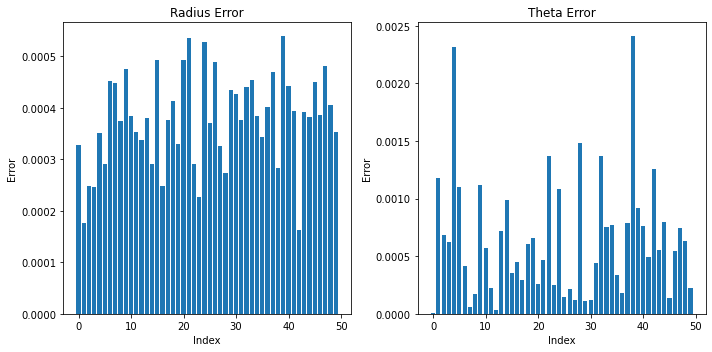

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.bar(ind,r_error)
plt.title("Radius Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()

plt.subplot(1,2,2)
plt.bar(ind,theta_error)
plt.title("Theta Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()

In [11]:
print("done")

done
